In [32]:
%matplotlib inline

# Code to plot figures in the LamaH-Ice paper (Helgason and Nijssen, 2024)

In [79]:
import pandas as pds
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from pathlib import Path
import pickle
import datetime as dt
import geopandas as gpds
import xarray as xr
from sklearn.preprocessing import MinMaxScaler
import os
import seaborn as sns
sns.set()

In [69]:
# Define the base path to the LamaH-Ice dataset
lamah_ice_path = Path(r'C:\Users\hordurbhe\Documents\Vinna\lamah\lamah_ice\lamah_ice')

# Define the relative path to the attributes geopackage. This includes a combination of catchment attributes,
# gauge attributes and meteorological means used in the plotting 
attrs_path = Path(r'F_appendix\1_codes\plots\Catchment_and_gauge_attributes_used_for_plotting.gpkg')

# Combine the paths
combined_attrs_path = lamah_ice_path.joinpath(attrs_path)

# Read the attributes file
merged_dff = gpds.read_file(combined_attrs_path, driver='GPKG')
merged_dff.set_index('id',inplace=True)

# Prepare water balance plots

In [35]:
# We read glacier weather:
# Read RAV-II data
start='1990-10-01'
rav_end = '2019-08-31'
rav_dict = dict()
for wshed in [20000,20001,20002]:
    path = Path(r'C:\Users\hordurbhe\Documents\Vinna\lamah\lamah_ice\rav2\ID_%s.csv' % wshed)
    df = pds.read_csv(path)
    df = df.set_index('Time')
    df.index = pds.to_datetime(df.index)
    df = df[start:rav_end]
    rav_dict[wshed] = df

# Read CARRA data    
carra_start='1991-10-01'
carra_end = '2022-08-31'
carra_dict = dict()
for wshed in [20000,20001,20002]:
    path = Path(r'C:\Users\hordurbhe\Documents\Vinna\lamah\lamah_ice\carra\precip_daily\ID_%s.csv' % wshed)
    df = pds.read_csv(path)
    df = df.set_index('time')
    df.index = pds.to_datetime(df.index)
    df = df[carra_start:carra_end]
    carra_dict[wshed] = df

# Read ERA5-land precip
era_path=Path(r"C:\Users\hordurbhe\Documents\Vinna\lamah\lamah_ice\era5_land\ts_glaciers\daily\ERA5L_total_precipitation.csv")
era = pds.read_csv(era_path)
era5=era.set_index('YYYY MM DD')
era5.index = pds.to_datetime(era5.index)

# Create lists containing annual winter accumulation from era5land
vatna_list = []
lang_list = []
hofs_list = []
for year in range(1992,2022):
    start = '%s-10-15' % int(year-1)
    end = '%s-05-01' % year
    winter_precip = era5[start:end].sum()
    vatna_list.append(winter_precip['1'])
    lang_list.append(winter_precip['2'])
    hofs_list.append(winter_precip['3'])

# Create lists containing annual winter accumulation from rav-ii
vatna_list_rav = []
lang_list_rav = []
hofs_list_rav = []
for year in range(1992,2020):
    start = '%s-10-15' % int(year-1)
    end = '%s-05-01' % year
    vatna_list_rav.append(rav_dict[20000][start:end].sum())
    lang_list_rav.append(rav_dict[20001][start:end].sum())
    hofs_list_rav.append(rav_dict[20002][start:end].sum())
    
# Create lists containing annual winter accumulation from CARRA
vatna_list_carra = []
lang_list_carra = []
hofs_list_carra = []
for year in range(1992,2023):
    start = '%s-10-15' % int(year-1)
    end = '%s-05-01' % year
    vatna_list_carra.append(carra_dict[20000][start:end].sum())
    lang_list_carra.append(carra_dict[20001][start:end].sum())
    hofs_list_carra.append(carra_dict[20002][start:end].sum())
    
lang_slod = Path(r"C:\Users\hordurbhe\OneDrive - Landsvirkjun\afkomukort\Langjokull_SMB_maps_2022_11_16.nc")
vatna_slod = Path(r"C:\Users\hordurbhe\OneDrive - Landsvirkjun\afkomukort\Vatnajokull_SMB_maps_2022_11_16.nc")
ds_lang = xr.open_dataset(lang_slod)
ds_vatna = xr.open_dataset(vatna_slod)

# Prepare figure plotting

In [54]:
today = dt.date.today()
today_str = '%s-%s-%s' % (today.year,today.month,today.day)

In [36]:
# Specify some plot attributes
iceland_shapefile_color = 'gray'
glaciers_color = 'white'

# Specify where to save the figures
savepath = Path(r'C:\Users\hordurbhe\Dropbox\UW\lamah_ice\paper\figures\final_revised_manuscript')

# Define the date string for plot savenames
today = dt.date.today()
today_str = '%s-%s-%s' % (today.year,today.month,today.day)

# Set figure limits
minx, miny = 222375, 307671
maxx, maxy = 765246, 697520

# Define the plot helper function
def plot_figs(basemap,glaciers,ax,iceland_shapefile_color,glaciers_color):
    # This function plots the basemap, the glaciers and sets x,ylimits and x,yticks
    bmap.plot(ax=ax, color=iceland_shapefile_color)
    glaciers.plot(ax=ax,facecolor=glaciers_color,edgecolor='none')
    ax.set_xlim(minx,maxx)
    ax.set_ylim(miny,maxy)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_frame_on(False)
    
# Read basemap for Iceland
bmap = gpds.read_file(r'C:\Users\hordurbhe\Documents\Vinna\lamah\lamah_ice\stanford-xz811fy7881-shapefile\island_isn93.shp')

# Read glacier outlines
gpath = Path(r'C:\Users\hordurbhe\Dropbox\UW\lamah_ice\GIS\glacier_outlines_from_is50V.shp')
glaciers = gpds.read_file(gpath)

# Plot all figures in the paper:

# Data availability plots:

In [37]:
column = 'year_count_1981_2021'
merged_dff_to_plot = merged_dff[merged_dff[column] > 2]
print('The number of gauges with >90%% coverage in 1981-2021: %s' % len(merged_dff_to_plot[column]))

The number of gauges with >90% coverage in 1981-2021: 72


In [38]:
column = 'year_count_1981_2021_unfilt'
merged_dff_to_plot = merged_dff[merged_dff[column] > 2]
print('The number of gauges with >90%% coverage in 1981-2021: %s' % len(merged_dff_to_plot[column]))

The number of gauges with >90% coverage in 1981-2021: 97


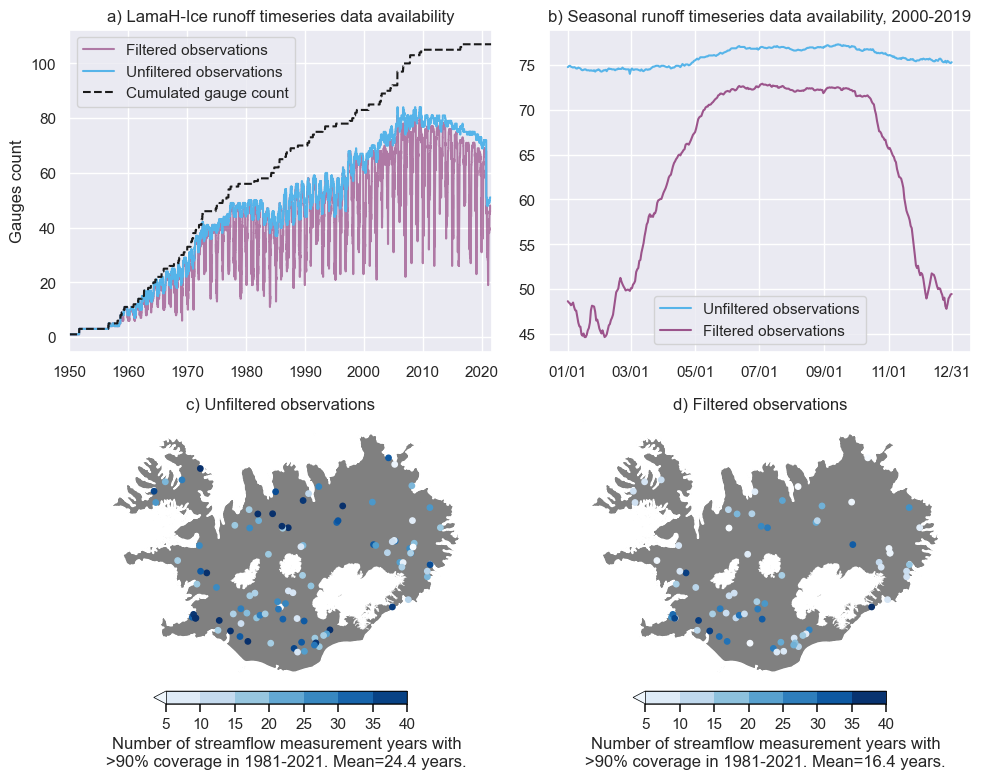

In [40]:
# Plot all plots in a 4x4 plot

# Read the measured streamflow (pickle files):
save_date = 'apr9_2024'
streamflow_savepath = Path(r"C:\Users\hordurbhe\Dropbox\UW\lamah_ice\discharge_measurements\processed_by_hh\combined_gauges_LV_VI_raw_%s.p" % save_date)
combined_dict_npc_met_office = pickle.load(open( streamflow_savepath, "rb" ) )
streamflow_savepath = Path(r"C:\Users\hordurbhe\Dropbox\UW\lamah_ice\discharge_measurements\processed_by_hh\combined_gauges_LV_VI_highqual_%s.p" % save_date)
combined_dict_high_qual = pickle.load(open( streamflow_savepath, "rb" ) )

# Create a 2x2 subplot layout
fig, axs = plt.subplots(2, 2, figsize=(10, 8))

# First plot (top-left)
# Filtered data:
values_dict = {}
for site in combined_dict_high_qual.keys():
    df = combined_dict_high_qual[site]['Value'].copy()
    df.index = pds.to_datetime(df.index)
    df.index = df.index.date
    values_dict[site] = df
values_df_filtered = pds.DataFrame(values_dict)
values_df_filtered.index = pds.to_datetime(values_df_filtered.index)
values_df_filtered.count(axis=1).plot(label='Filtered observations', alpha=0.6, ax=axs[0, 0], c='#882E72') 

# Unfiltered data:
values_dict = {}
for site in combined_dict_npc_met_office.keys():
    df = combined_dict_npc_met_office[site]['Value'].copy()
    df.index = pds.to_datetime(df.index)
    df.index = df.index.date
    values_dict[site] = df
values_df = pds.DataFrame(values_dict)
values_df.index = pds.to_datetime(values_df.index)
values_df.count(axis=1).plot(label='Unfiltered observations', ax=axs[0, 0], c='#56B4E9')

# Cumulated gauge count (continued in first plot)
index = pds.date_range('1930-01-01', '2021-09-30')
data = np.zeros(len(index))
cum_values_df = pds.DataFrame(data=data, index=index, columns=['Value'])
for site in combined_dict_npc_met_office.keys():
    df = combined_dict_npc_met_office[site]['Value'].copy()
    df.index = pds.to_datetime(df.index)
    df.index = df.index.date
    start_date = df.index[0]
    cum_values_df['Value'][start_date:] += 1
cum_values_df['Value'].plot(label='Cumulated gauge count', ax=axs[0, 0], c='k',linestyle='--')

axs[0, 0].legend()
axs[0, 0].set_title('a) LamaH-Ice runoff timeseries data availability')
axs[0, 0].set_ylabel('Gauges count')
axs[0, 0].set_xlim(['1950-01-01', '2021-09-01'])

# Second plot (top-right) - Seasonal runoff timeseries
to_plot = values_df['2000-01-01':'2019-12-31'].count(axis=1).groupby(values_df['2000-01-01':'2019-12-31'].index.strftime("%m/%d")).mean()
to_plot.plot(label='Unfiltered observations', ax=axs[0, 1], c='#56B4E9')
to_plot2 = values_df_filtered['2000-01-01':'2019-12-31'].count(axis=1).groupby(values_df_filtered['2000-01-01':'2019-12-31'].index.strftime("%m/%d")).mean()
to_plot2.plot(label='Filtered observations', ax=axs[0, 1], alpha=0.8, c='#882E72')
axs[0, 1].set_title('b) Seasonal runoff timeseries data availability, 2000-2019')
axs[0, 1].legend()
axs[0, 1].set_xticks(np.array([0, 60, 121, 182, 244, 305, 365]))
axs[0, 1].set_xticklabels(['01/01', '03/01', '05/01', '07/01', '09/01', '11/01', '12/31'])

# Third plot (bottom-left) - Unfiltered observations map
# Unfiltered observations:
column = 'year_count_1981_2021_unfilt'
merged_dff_to_plot = merged_dff[merged_dff[column] > 2]

# Plot basemap, glaciers and set fig aesthetics
plot_figs(bmap,glaciers,axs[1, 0],iceland_shapefile_color,glaciers_color)

merged_dff_to_plot.plot(column=column, s=15, 
               legend=True, legend_kwds={'label': "Number of streamflow measurement years with\n>90%% coverage in 1981-2021. Mean=%0.1f years." % merged_dff_to_plot[column].mean(),
                                         'orientation': "horizontal",
                                         'shrink': 0.6, 'pad':0.03, 'boundaries':[5,10,15,20,25,30,35,40],'extend':'min'},
               ax=axs[1, 0], cmap='Blues') 

# Set colorbar frame
fig = axs[1,0].figure
cbar = fig.axes[-1] 
cbar.set_frame_on(True)  # Add a frame to the colorbar
# Explicitly set spine properties
for spine in cbar.spines.values():
    spine.set_visible(True)
    spine.set_linewidth(0.5)  # Increase linewidth to make it more visible
    spine.set_edgecolor('black')  # Change the color if needed
    
axs[1, 0].set_title('c) Unfiltered observations')

# Fourth plot (bottom-right) - Filtered observations map
column = 'year_count_1981_2021'
merged_dff_to_plot = merged_dff[merged_dff[column] > 2]

# Plot basemap, glaciers and set fig aesthetics
plot_figs(bmap,glaciers,axs[1, 1],iceland_shapefile_color,glaciers_color)

merged_dff_to_plot.plot(column=column, s=15, 
               legend=True, legend_kwds={'label': "Number of streamflow measurement years with\n>90%% coverage in 1981-2021. Mean=%0.1f years." % merged_dff_to_plot[column].mean(),
                                         'orientation': "horizontal",
                                         'shrink': 0.6, 'pad':0.03, 'boundaries':[5,10,15,20,25,30,35,40],'extend':'min'},
               ax=axs[1, 1], cmap='Blues') 

# Set colorbar frame
fig = axs[1,1].figure
cbar = fig.axes[-1] 
cbar.set_frame_on(True)  # Add a frame to the colorbar

# Explicitly set spine properties
for spine in cbar.spines.values():
    spine.set_visible(True)
    spine.set_linewidth(0.5)  # Increase linewidth to make it more visible
    spine.set_edgecolor('black')  # Change the color if needed

axs[1, 1].set_title('d) Filtered observations')

plt.tight_layout()

# Save the figure 
savestr = 'streamflow_data_availability_plots_combined_%s.png' % today_str
plt.savefig(savepath/savestr,dpi=300,bbox_inches='tight')

# Print stats mentioned in the paper regarding streamflow data coverage:

In [13]:
# Maximum number of simultaniously reporting gauges:
values_df.count(axis=1).max()

84

In [ ]:
# When?

In [15]:
max_value = values_df.count(axis=1).max()

# Find all indices where the count equals the maximum value
max_indices = values_df.count(axis=1)[values_df.count(axis=1) == max_value].index.tolist()

unique_years = set(timestamp.year for timestamp in max_indices)
print(sorted(unique_years))

[2005, 2006, 2008, 2009]


In [ ]:
# There are 84 gauges reporting simultaneously on 4 occasions:

<Axes: >

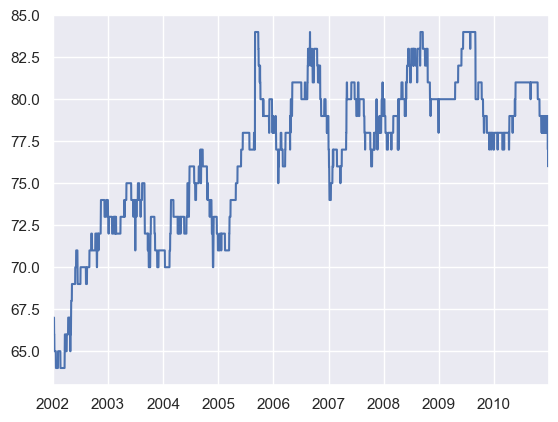

In [16]:
values_df.count(axis=1)['2002-01-01':'2010-12-31'].plot()

In [17]:
# Find the year with the highest average coverage:

In [18]:
values_df.count(axis=1).resample('Y').mean().idxmax()

Timestamp('2009-12-31 00:00:00')

In [42]:
values_df.count(axis=1).resample('Y').mean().max()

80.86849315068493

In [43]:
# Minimum number between 2006 and 2020:
values_df.count(axis=1)['2006-01-01':'2019-12-31'].min()

70

In [44]:
# Minimum number between 2006 and 2020:
values_df.count(axis=1)['2006-01-01':'2019-12-31'].max()

84

In [20]:
# The mean number of filtered obs gauges in summer:
to_plot2['06/01':'08/31'].mean()

72.38804347826088

In [21]:
# In winter (DEC-FEB):
(2*(to_plot2['01/01':'02/28'].mean())+to_plot2['12/01':'12/31'].mean())/3

48.2308456351376

# Water balance plots:

In [82]:
# Here we remove gauges 890, 990, 1010 and 9900 from the merged_dff.
# These gauges are duplicates of gauges 89, 99 and 101. 
# The watersheds of these duplicate gauges have been altered by river diversions, 
# as described in the Supplement (S2.3) of the LamaH-Ice paper. 
# We remove these gauges in the figure plotting for clarity.
merged_dff = merged_dff[:-4]

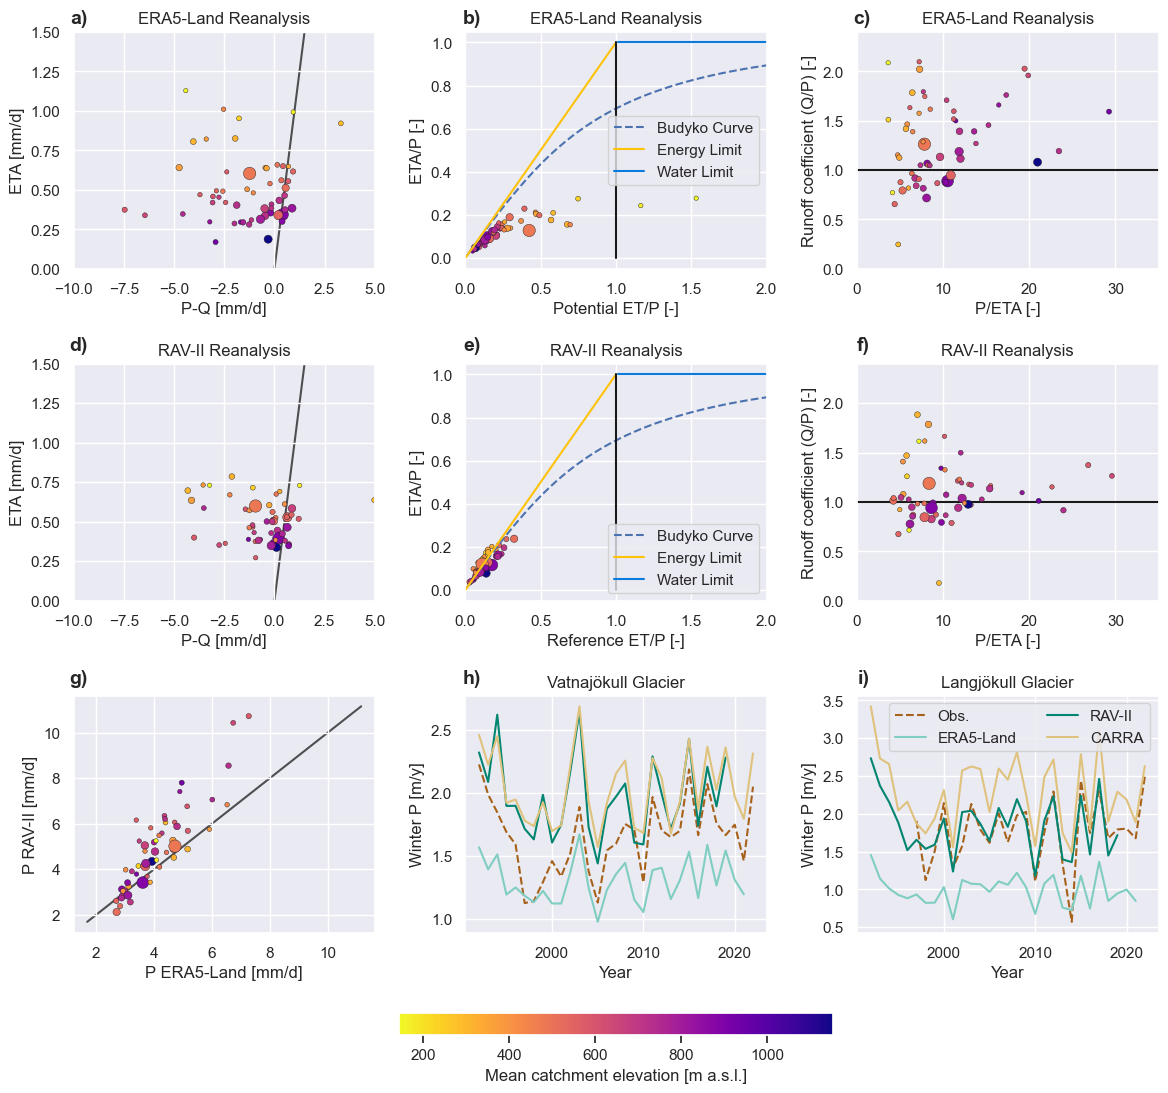

In [23]:
# Define a color palette for portraying the catchment elevations
cmap = 'plasma_r'

# Create six subplots in a 2x3 grid
fig, axs = plt.subplots(nrows=3, ncols=3, figsize=(14,15))

# A) Water Balance Plots
ax = axs[0,0]

x = merged_dff['P_ERA5L'].where(merged_dff['degimpact']!='s') - merged_dff['Q'].where(merged_dff['degimpact']!='s')
y = merged_dff['ET_ERA5L'].where(merged_dff['degimpact']!='s') #valid_eta_arr
s = merged_dff['area_calc'] # assign 'area_calc' column to s parameter
c = merged_dff['elev_mean']

# scale the values in the 'area_calc' column to a range between 10 and 500
scaler = MinMaxScaler(feature_range=(10, 100))
s_scaled = scaler.fit_transform(s.values.reshape(-1, 1)).flatten()

ax.scatter(x, y, s=s_scaled, c=c, cmap=cmap,edgecolor='k', linewidths=0.3, label='ERA5-Land')

# add colorbar
ax.set_xlim([-10,5])
ax.minorticks_on()

ax.set_ylabel('ETA [mm/d]')
ax.set_xlabel('P-Q [mm/d]')
lims = [
    np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
    np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
]

# now plot both limits against eachother
ax.plot(lims, lims, 'k-', alpha=0.75, zorder=0,label='1:1 line')
ax.set_xlim([-10,5])
ax.set_ylim([0,1.5])
ax.set_title('ERA5-Land Reanalysis')

# B) Budyko plot
ax = axs[0,1]

# Calculate Budyko values for ERA5-Land
bud_y = merged_dff['ET_ERA5L'].where(merged_dff['degimpact']!='s') / merged_dff['P_ERA5L'].where(merged_dff['degimpact']!='s')
bud_x = merged_dff['PET_ERA5L'].where(merged_dff['degimpact']!='s') / merged_dff['P_ERA5L'].where(merged_dff['degimpact']!='s')

budyko_curve_x = np.arange(0.01, 4, 0.05)
energy_limit_x = np.arange(0, 1.0001, 0.05)
x = np.arange(0, 1.0001, 0.05)
budyko_curve_y = np.power((budyko_curve_x*np.tanh(1/budyko_curve_x)*(1-np.exp(-budyko_curve_x))),0.5)
water_limit_y = 1+budyko_curve_x*0
energy_limit_y = energy_limit_x
y = 1 + x*0

ax.plot(budyko_curve_x,budyko_curve_y,  linestyle='--') #,c='k')
ax.plot(energy_limit_y,energy_limit_x, c='#FFC20A') #c='y')
ax.plot(budyko_curve_x[20:],water_limit_y[20:],c='#0C7BDC') #,c='b',alpha=0.5)
ax.plot(y,x,linestyle='-', c='k',label='_nolegend_')

ax.scatter(bud_x, bud_y, s=s_scaled, c=c, cmap=cmap,edgecolor='k', linewidths=0.3,label=False)#, label='ERA5-Land')

ax.set_ylabel("ETA/P [-]")
ax.set_xlabel("Potential ET/P [-]")
ax.set_xlim([0,2])

ax.legend(["Budyko Curve","Energy Limit", "Water Limit"])#,"LamaH-Ice"]) #,"LamaH-CE"])
ax.set_title('ERA5-Land Reanalysis')


# C) Runoff coefficient vs. precip
ax = axs[0,2]
ax.plot([0,40], [1,1], 'k-', zorder=1)#,label='1:1 line')

x = merged_dff['P_ERA5L'].where(merged_dff['degimpact']!='s') / merged_dff['ET_ERA5L'].where(merged_dff['degimpact']!='s')
y = merged_dff['Q'].where(merged_dff['degimpact']!='s')/merged_dff['P_ERA5L'].where(merged_dff['degimpact']!='s')
ax.scatter(x, y, s=s_scaled, c=c, cmap=cmap,edgecolor='k', linewidths=0.3, label='ERA5-Land')

ax.set_ylabel("Runoff coefficient (Q/P) [-]")
ax.set_xlabel("P/ETA [-]")
ax.set_ylim([0,2.4])
ax.set_xlim([0,35])
ax.set_title('ERA5-Land Reanalysis')


# D) Water Balance Plots for rav2 (copy of plot A with changes)
ax = axs[1,0]

x = merged_dff['P_rav'].where(merged_dff['degimpact']!='s') - merged_dff['Q'].where(merged_dff['degimpact']!='s')
y = merged_dff['ET_rav'].where(merged_dff['degimpact']!='s') #valid_eta_arr
s = merged_dff['area_calc'] # assign 'area_calc' column to s parameter
c = merged_dff['elev_mean']

# scale the values in the 'area_calc' column to a range between 10 and 500
scaler = MinMaxScaler(feature_range=(10, 100))
s_scaled = scaler.fit_transform(s.values.reshape(-1, 1)).flatten()

ax.scatter(x, y, s=s_scaled, c=c, cmap=cmap,edgecolor='k', linewidths=0.3, label='ERA5-Land')

# add colorbar
ax.set_xlim([-10,5])
ax.minorticks_on()

ax.set_ylabel('ETA [mm/d]')
ax.set_xlabel('P-Q [mm/d]')
lims = [
    np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
    np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
]

# now plot both limits against eachother
ax.plot(lims, lims, 'k-', alpha=0.75, zorder=0,label='1:1 line')
ax.set_xlim([-10,5])
ax.set_ylim([0,1.5])
ax.set_title('RAV-II Reanalysis')

# E) Budyko plot for ERA5L (copy of plot B with changes)
ax = axs[1,1]

# Calculate Budyko values for ERA5-Land
bud_y = merged_dff['ET_rav'].where(merged_dff['degimpact']!='s') / merged_dff['P_rav'].where(merged_dff['degimpact']!='s')
bud_x = merged_dff['PET_rav'].where(merged_dff['degimpact']!='s') / merged_dff['P_rav'].where(merged_dff['degimpact']!='s')

budyko_curve_x = np.arange(0.01, 4, 0.05)
energy_limit_x = np.arange(0, 1.0001, 0.05)
x = np.arange(0, 1.0001, 0.05)
budyko_curve_y = np.power((budyko_curve_x*np.tanh(1/budyko_curve_x)*(1-np.exp(-budyko_curve_x))),0.5)
water_limit_y = 1+budyko_curve_x*0
energy_limit_y = energy_limit_x
y = 1 + x*0

ax.plot(budyko_curve_x,budyko_curve_y,  linestyle='--') #,c='k')
ax.plot(energy_limit_y,energy_limit_x, c='#FFC20A') #c='y')
ax.plot(budyko_curve_x[20:],water_limit_y[20:],c='#0C7BDC') #,c='b',alpha=0.5)
ax.plot(y,x,linestyle='-', c='k',label='_nolegend_')

ax.scatter(bud_x, bud_y, s=s_scaled, c=c, cmap=cmap,edgecolor='k', linewidths=0.3,label=False)#, label='ERA5-Land')

ax.set_ylabel("ETA/P [-]")
ax.set_xlabel("Reference ET/P [-]")
ax.set_xlim([0,2])

ax.legend(["Budyko Curve","Energy Limit", "Water Limit"])
ax.set_title('RAV-II Reanalysis')

# F) Runoff coefficient vs. precip for rav2 (copy of plot C with changes)
ax = axs[1,2]

ax.plot([0,40], [1,1], 'k-', zorder=1)

x = merged_dff['P_rav'].where(merged_dff['degimpact']!='s') / merged_dff['ET_rav'].where(merged_dff['degimpact']!='s')
y = merged_dff['Q'].where(merged_dff['degimpact']!='s')/merged_dff['P_rav'].where(merged_dff['degimpact']!='s')
ax.scatter(x, y, s=s_scaled, c=c, cmap=cmap,edgecolor='k', linewidths=0.3, label='ERA5-Land')

ax.set_ylabel("Runoff coefficient (Q/P) [-]")
ax.set_xlabel("P/ETA [-]")
ax.set_ylim([0,2.4])
ax.set_xlim([0,35])
ax.set_title('RAV-II Reanalysis')

# G) RAV-II vs. ERA5-Land
ax = axs[2,0] 
im=ax.scatter(merged_dff['P_ERA5L'].where(merged_dff['degimpact']!='s'),merged_dff['P_rav'].where(merged_dff['degimpact']!='s'),s=s_scaled, c=c, cmap=cmap,edgecolor='k', linewidths=0.3)
ax.set_ylabel("P RAV-II [mm/d]")
ax.set_xlabel("P ERA5-Land [mm/d]")

lims = [
    np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
    np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
]

# now plot both limits against eachother
ax.plot(lims, lims, 'k-', alpha=0.75, zorder=0)#,label='1:1 line')

# Define colors to be used in subfigures E and F
era5l_c = '#80cdc1'
obs_c = '#a6611a'
rav_c = '#018571'
carra_c = '#dfc27d'

# H) Precip vs. observed winter snow accumulation on Vatnajökull
ax = axs[2,1] 
startyear = 1992
endyear = 2021
era_df = pds.DataFrame(data=np.array(vatna_list),index=range(1992,2022))
rav_df = pds.DataFrame(data=np.array(vatna_list_rav),index=range(1992,2020))
carra_df = pds.DataFrame(data=np.array(vatna_list_carra),index=range(1992,2023))

obs_mean = ds_vatna.bw.mean(dim=['x','y'])
df_obs = pds.DataFrame(data=obs_mean.values, index=[int(x) for x in obs_mean.to_dataframe().index])
(df_obs).plot(ls='--',ax=ax,legend=False,c=obs_c)
(era_df/1000).plot(ax=ax,legend=False,c=era5l_c)
(rav_df/1000).plot(ax=ax,legend=False,c=rav_c)
(carra_df/1000).plot(ax=ax,legend=False,c=carra_c)
ax.set_ylabel('Winter P [m/y]')
ax.set_title('Vatnajökull Glacier')

# create a formatter object with 2 decimal places
fmt = '%.1f'
y_formatter = ticker.FormatStrFormatter(fmt)

# apply the formatter to the y-axis ticks
ax.yaxis.set_major_formatter(y_formatter)
ax.set_xlabel('Year')


# I) Precip vs. observed winter snow accumulation on Langjökull
ax = axs[2,2] 
startyear = 1992
endyear = 2021
era_df = pds.DataFrame(data=np.array(lang_list),index=range(1992,2022))
rav_df = pds.DataFrame(data=np.array(lang_list_rav),index=range(1992,2020))
carra_df = pds.DataFrame(data=np.array(lang_list_carra),index=range(1992,2023))

obs_mean = ds_lang.bw.mean(dim=['x','y'])
df_obs = pds.DataFrame(data=obs_mean.values, index=[int(x) for x in obs_mean.to_dataframe().index])
(df_obs).plot(ls='--',ax=ax, c=obs_c)
(era_df/1000).plot(ax=ax, c=era5l_c)
(rav_df/1000).plot(ax=ax,c=rav_c)
(carra_df/1000).plot(ax=ax,legend=False, c=carra_c)

ax.legend(labels=['Obs.','ERA5-Land','RAV-II','CARRA'], loc='upper left', ncol=2, bbox_to_anchor=(0.08, 1.0))

ax.set_ylabel('Winter P [m/y]')
ax.set_xlabel('Year')
ax.set_title('Langjökull Glacier')

# update subplot labels for all plots
fig.text(0.135, 0.895, "a)", fontsize=14, fontweight='bold', va='top', ha='right')
fig.text(0.416, 0.895, "b)", fontsize=14, fontweight='bold', va='top', ha='right')
#fig.text(0.692, 0.895, "c)", fontsize=14, fontweight='bold', va='top', ha='right')
fig.text(0.694, 0.895, "c)", fontsize=14, fontweight='bold', va='top', ha='right')
fig.text(0.135, 0.677, "d)", fontsize=14, fontweight='bold', va='top', ha='right')
fig.text(0.416, 0.677, "e)", fontsize=14, fontweight='bold', va='top', ha='right')
fig.text(0.694, 0.677, "f)", fontsize=14, fontweight='bold', va='top', ha='right')
fig.text(0.135, 0.455, "g)", fontsize=14, fontweight='bold', va='top', ha='right')
fig.text(0.416, 0.455, "h)", fontsize=14, fontweight='bold', va='top', ha='right')
fig.text(0.694, 0.455, "i)", fontsize=14, fontweight='bold', va='top', ha='right')

# adjust spacing between subplots to prevent labels from overlapping with titles
fig.subplots_adjust(hspace=0.5, wspace=0.3)

# adjust spacing between subplots to prevent labels from overlapping with titles
fig.subplots_adjust(hspace=0.4)
# add a colorbar that is shared among all subplots
cbar = fig.colorbar(im, ax=axs, shrink=0.4,orientation='horizontal',pad=0.07)
cbar.set_label('Mean catchment elevation [m a.s.l.]')#, rotation=270)

# Save the plot
savestr = 'water_balance_plots_final_%s.png' % today_str
plt.savefig(savepath/savestr,dpi=300,bbox_inches='tight')

# Supplement figure: Plot CARRA precip against ERA5-Land precip

C:\Users\hordurbhe\AppData\Local\Temp\ipykernel_23160\2183910437.py:71: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


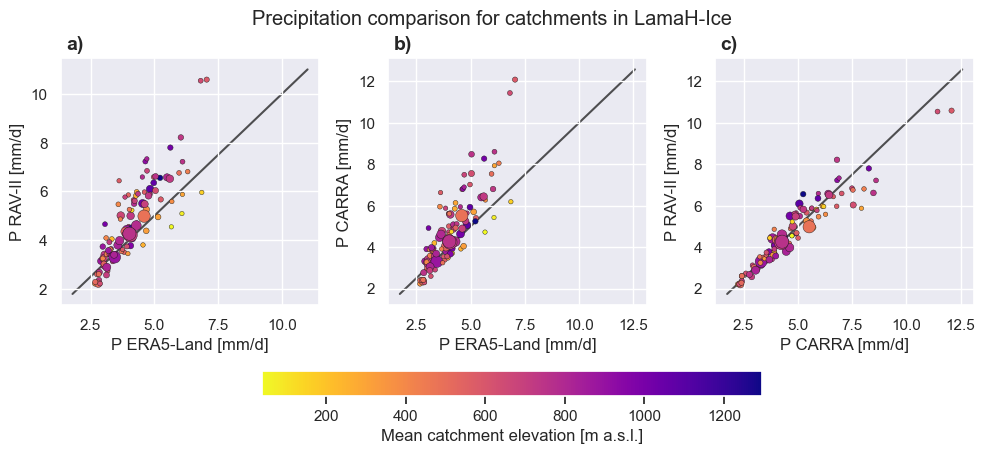

In [24]:
import matplotlib.pyplot as plt
import numpy as np

# Now we turn on seaborn effects
import seaborn as sns
sns.set()

# Define a color palette for portraying the catchment elevations
cmap = 'plasma_r'
s = merged_dff['area_calc'] # assign 'area_calc' column to s parameter
c = merged_dff['elev_mean']

# scale the values in the 'area_calc' column to a range between 10 and 500
scaler = MinMaxScaler(feature_range=(10, 100))
s_scaled = scaler.fit_transform(s.values.reshape(-1, 1)).flatten()

# merged_dff is the DataFrame containing the data
# and s_scaled, c, cmap are defined for scatter plot aesthetics

rav_col = 'P_ravII_1991'
carra_col = 'P_carra_1991'
era5l_col = 'P_ERA5L_1991'

fig, axs = plt.subplots(1, 3, figsize=(10, 3.2))  # 1 row, 3 columns

# Plot 1: P_ravII vs. P_ERA5L
ax = axs[0]
im = ax.scatter(merged_dff[era5l_col], merged_dff[rav_col], s=s_scaled, c=c, cmap=cmap, edgecolor='k', linewidths=0.3)
ax.set_xlabel("P ERA5-Land [mm/d]")
ax.set_ylabel("P RAV-II [mm/d]")
# Adjusting limits to fit 1:1 line
lims1 = [
    np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
    np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
]
ax.plot(lims1, lims1, 'k-', alpha=0.75, zorder=0)

# Plot 2: P_carra vs. P_ERA5L
ax = axs[1]
im = ax.scatter(merged_dff[era5l_col], merged_dff[carra_col], s=s_scaled, c=c, cmap=cmap, edgecolor='k', linewidths=0.3)
ax.set_xlabel("P ERA5-Land [mm/d]")
ax.set_ylabel("P CARRA [mm/d]")
# Adjusting limits to fit 1:1 line
lims2 = [
    np.min([ax.get_xlim(), ax.get_ylim()]),
    np.max([ax.get_xlim(), ax.get_ylim()]),
]
ax.plot(lims2, lims2, 'k-', alpha=0.75, zorder=0)

# Plot 3: P_ravII vs. P_carra
ax = axs[2]
im = ax.scatter(merged_dff[carra_col], merged_dff[rav_col], s=s_scaled, c=c, cmap=cmap, edgecolor='k', linewidths=0.3)
ax.set_xlabel("P CARRA [mm/d]")
ax.set_ylabel("P RAV-II [mm/d]")
# Adjusting limits to fit 1:1 line
lims3 = [
    np.min([ax.get_xlim(), ax.get_ylim()]),
    np.max([ax.get_xlim(), ax.get_ylim()]),
]
ax.plot(lims3, lims3, 'k-', alpha=0.75, zorder=0)

# add a colorbar that is shared among all subplots
cbar = fig.colorbar(im, ax=axs, shrink=0.4,orientation='horizontal',pad=0.1)
cbar.set_label('Mean catchment elevation [m a.s.l.]')#, rotation=270)

cbar.ax.set_position([0.27, -0.35, 0.5, 0.2])
plt.suptitle('Precipitation comparison for catchments in LamaH-Ice')

# Adjust layout
plt.tight_layout()

axs[0].text(0.02, 1.09, 'a)', transform=axs[0].transAxes, va='top', ha='left', fontsize=14, weight='bold')
axs[1].text(0.02, 1.09, 'b)', transform=axs[1].transAxes, va='top', ha='left', fontsize=14, weight='bold')
axs[2].text(0.02, 1.09, 'c)', transform=axs[2].transAxes, va='top', ha='left', fontsize=14, weight='bold')

# Save the plot
savestr = 'precip_comparison_%s.png' % today_str
plt.savefig(savepath/savestr,dpi=300,bbox_inches='tight')
plt.show()

# Supplement figure: Plot Budyko analysis with uniterrupted data from 1981

In [25]:
P_rav_col = 'P_ravII_1981'
P_era5l_col = 'P_ERA5L_1981'

ET_rav_col = 'ET_ravII_1981'
ET_era5L_col ='ET_ERA5L_1981'

PET_rav_col = 'PET_ravII_1981'
PET_era5L_col = 'PET_ERA5L_1981'

C:\Users\hordurbhe\AppData\Local\Temp\ipykernel_23160\3811908225.py:23: RuntimeWarning: divide by zero encountered in divide
  budyko_curve_y = np.power((budyko_curve_x*np.tanh(1/budyko_curve_x)*(1-np.exp(-budyko_curve_x))),0.5)
C:\Users\hordurbhe\AppData\Local\Temp\ipykernel_23160\3811908225.py:52: RuntimeWarning: divide by zero encountered in divide
  budyko_curve_y = np.power((budyko_curve_x*np.tanh(1/budyko_curve_x)*(1-np.exp(-budyko_curve_x))),0.5)
C:\Users\hordurbhe\AppData\Local\Temp\ipykernel_23160\3811908225.py:78: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


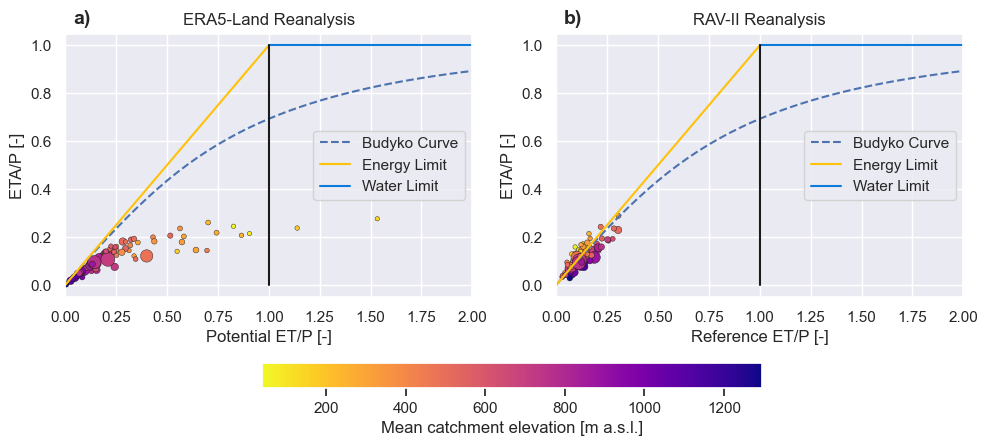

In [26]:
# Define a color palette for portraying the catchment elevations
cmap = 'plasma_r'
s = merged_dff['area_calc'] # assign 'area_calc' column to s parameter
c = merged_dff['elev_mean']

# scale the values in the 'area_calc' column to a range between 10 and 500
scaler = MinMaxScaler(feature_range=(10, 100))
s_scaled = scaler.fit_transform(s.values.reshape(-1, 1)).flatten()

# merged_dff is the DataFrame containing the data
# and s_scaled, c, cmap are defined for scatter plot aesthetics
fig, axs = plt.subplots(1, 2, figsize=(10, 3.2))  # 1 row, 3 columns

ax = axs[0]

# Calculate Budyko values for ERA5-Land
bud_y = merged_dff[ET_era5L_col] / merged_dff[P_era5l_col]
bud_x = merged_dff[PET_era5L_col] / merged_dff[P_era5l_col]

budyko_curve_x = np.arange(0, 4, 0.05)
energy_limit_x = np.arange(0, 1.0001, 0.05)
x = np.arange(0, 1.0001, 0.05)
budyko_curve_y = np.power((budyko_curve_x*np.tanh(1/budyko_curve_x)*(1-np.exp(-budyko_curve_x))),0.5)
water_limit_y = 1+budyko_curve_x*0
energy_limit_y = energy_limit_x
y = 1 + x*0

ax.plot(budyko_curve_x,budyko_curve_y,  linestyle='--') 
ax.plot(energy_limit_y,energy_limit_x, c='#FFC20A') 
ax.plot(budyko_curve_x[20:],water_limit_y[20:],c='#0C7BDC') 
ax.plot(y,x,linestyle='-', c='k',label='_nolegend_')

im = ax.scatter(bud_x, bud_y, s=s_scaled, c=c, cmap=cmap,edgecolor='k', linewidths=0.3,label=False)#, label='ERA5-Land')

ax.set_ylabel("ETA/P [-]")
ax.set_xlabel("Potential ET/P [-]")
ax.set_xlim([0,2])

ax.legend(["Budyko Curve","Energy Limit", "Water Limit"],loc='center right')
ax.set_title('ERA5-Land Reanalysis')

# H) Budyko plot for ERA5L (copy of plot B with changes)
ax = axs[1]

# Calculate Budyko values for ERA5-Land
bud_y = merged_dff[ET_rav_col] / merged_dff[P_rav_col]
bud_x = merged_dff[PET_rav_col] / merged_dff[P_rav_col]

budyko_curve_x = np.arange(0, 4, 0.05)
energy_limit_x = np.arange(0, 1.0001, 0.05)
x = np.arange(0, 1.0001, 0.05)
budyko_curve_y = np.power((budyko_curve_x*np.tanh(1/budyko_curve_x)*(1-np.exp(-budyko_curve_x))),0.5)
water_limit_y = 1+budyko_curve_x*0
energy_limit_y = energy_limit_x
y = 1 + x*0

ax.plot(budyko_curve_x,budyko_curve_y,  linestyle='--') 
ax.plot(energy_limit_y,energy_limit_x, c='#FFC20A') 
ax.plot(budyko_curve_x[20:],water_limit_y[20:],c='#0C7BDC')
ax.plot(y,x,linestyle='-', c='k',label='_nolegend_')

ax.scatter(bud_x, bud_y, s=s_scaled, c=c, cmap=cmap,edgecolor='k', linewidths=0.3,label=False)

ax.set_ylabel("ETA/P [-]")
ax.set_xlabel("Reference ET/P [-]")
ax.set_xlim([0,2])

ax.legend(["Budyko Curve","Energy Limit", "Water Limit"],loc='center right')
ax.set_title('RAV-II Reanalysis')


# add a colorbar that is shared among all subplots
cbar = fig.colorbar(im, ax=axs, shrink=0.4,orientation='horizontal',pad=0.1)
cbar.set_label('Mean catchment elevation [m a.s.l.]')

cbar.ax.set_position([0.27, -0.35, 0.5, 0.2])
# Adjust layout
plt.tight_layout()
axs[0].text(0.02, 1.09, 'a)', transform=axs[0].transAxes, va='top', ha='left', fontsize=14, weight='bold')
axs[1].text(0.02, 1.09, 'b)', transform=axs[1].transAxes, va='top', ha='left', fontsize=14, weight='bold')

savestr = 'budyko_all_years_%s.png' % today_str
plt.savefig(savepath/savestr,dpi=300,bbox_inches='tight')
plt.show()

# Print statistics related to the water balance mentioned in the paper:

In [45]:
# Difference between ERA5-Land precip and discharge:
filtered_dff = merged_dff[(merged_dff['degimpact'] != 's') & (merged_dff['glac_fra'] <= 0.05)]
x_era = (filtered_dff['P_ERA5L']-filtered_dff['Q']).dropna().mean()
x_rav = (filtered_dff['P_rav']-filtered_dff['Q']).dropna().mean()

P_minus_Q_era = (merged_dff['P_ERA5L'].where(merged_dff['degimpact']!='s') - merged_dff['Q'].where(merged_dff['degimpact']!='s')).mean()
P_minus_Q_rav = (merged_dff['P_rav'].where(merged_dff['degimpact']!='s') - merged_dff['Q'].where(merged_dff['degimpact']!='s')).mean()
dff_larger_than_5perc_glac_filtered = merged_dff[(merged_dff['degimpact'] != 's') & (merged_dff['glac_fra'] > 0.05)]
nbasins_glac = len(dff_larger_than_5perc_glac_filtered['P_ERA5L'].dropna())

print('Difference between ERA5-Land precip and obs. discharge: %.3f mm/d' %P_minus_Q_era)
print('Difference between Rav precip and obs. discharge: %.3f mm/d' %P_minus_Q_rav)
print('P_era - obs. discharge where glaciated basins have been omitted: %.3f mm/d' % x_era.mean())
print('P_rav - obs. discharge where glaciated basins have been omitted: %.3f mm/d' % x_rav.mean())
print('The number of basins with more than 5%% glaciation is %s' %nbasins_glac)

era5_roff_ratio = merged_dff['Q'].where(merged_dff['degimpact']!='s') / merged_dff['P_ERA5L'].where(merged_dff['degimpact']!='s')
print('The number of basins with Q/P > 1 using ERA5-L precip is %s' % len(era5_roff_ratio[era5_roff_ratio>1])) #merged_dff['runoff_ratio'][merged_dff['runoff_ratio']>1]))

rav_roff_ratio = merged_dff['Q'].where(merged_dff['degimpact']!='s') / merged_dff['P_rav'].where(merged_dff['degimpact']!='s')
print('The number of basins with Q/P > 1 using RAV-II precip is %s' % len(rav_roff_ratio[rav_roff_ratio>1]))
print('Out of %s uninterupted basins' % len(merged_dff['Q'].where(merged_dff['degimpact']!='s').dropna()))

Difference between ERA5-Land precip and obs. discharge: -1.378 mm/d
Difference between Rav precip and obs. discharge: -0.584 mm/d
P_era - obs. discharge where glaciated basins have been omitted: -1.183 mm/d
P_rav - obs. discharge where glaciated basins have been omitted: -0.576 mm/d
The number of basins with more than 5% glaciation is 19
The number of basins with Q/P > 1 using ERA5-L precip is 39
The number of basins with Q/P > 1 using RAV-II precip is 32
Out of 55 uninterupted basins


# 5 Catchment characteristics

In [40]:
# Check correlations between catchment characteristics:
numeric_columns = merged_dff.select_dtypes(include=['number'])
corr = numeric_columns.corr()

# 5.1 Topographic indices

In [56]:
import matplotlib
matplotlib.rc_file_defaults()

# Print statistics mentioned in paper

In [183]:
# Define the relative path to the basins shapefile.
basins_path = Path(r'A_basins_total_upstrm\3_shapefiles\Basins_A.shp')

# Combine the paths
combined_basins_path = lamah_ice_path.joinpath(basins_path)

# Read the watersheds polygons
wsheds = gpds.read_file(combined_basins_path)
wsheds = wsheds.set_index('id')

wsheds_area = wsheds.geometry.area/1e6 
# Before calculating stats, remove the four watersheds that were altered due to diversions
wsheds_area = wsheds_area.drop([890,990,1010,9900])
wsheds_area = wsheds_area.sort_index()

# Print the area stats mentioned in the paper:
area_max = latest_wsheds_area.max()
area_min = latest_wsheds_area.min()
area_median = latest_wsheds_area.median()
area_mean = latest_wsheds_area.mean()
print('The values of area_max,area_min,area_median,area_mean are as follows (in km2):')
print(area_max,area_min,area_median,area_mean)

The values of area_max,area_min,area_median,area_mean are as follows (in km2):
7437.17264521241 3.8444 386.0704 899.2773586775263


In [105]:
gdf = wsheds.drop([890,990,1010,9900]).geometry.copy()
# Merge overlapping polygons into a single polygon
merged_polygon = gdf.geometry.unary_union

# Calculate the area of the merged polygon
area = merged_polygon.area

# Print the area
print("Total area covered by LamaH-Ice watersheds: %s km2" % ( area/1e6))

Total area covered by LamaH-Ice watersheds: 45944.72082678438 km2


In [184]:
# Define the relative path to the glacier polygon shapefile.
glaciers_path = Path(r'A_basins_total_upstrm\3_shapefiles\glaciers_in_catchments.shp')

# Combine the paths
combined_glaciers_path = lamah_ice_path.joinpath(glaciers_path)

# Read the glacier polygon shapefile
glaciers_polygons = gpds.read_file(combined_glaciers_path)
glaciers_polygons = glaciers_polygons.set_index('id').drop([990,1010,9900])
merged_glaciers = glaciers_polygons.geometry.unary_union

# Calculate the area of the merged polygon
area = merged_glaciers.area

# Print the area
print("Total glacierized area in LamaH-Ice: %s km2" % (area/1e6))

# Total glacier area in Iceland: 10,400 km2 (Hannesdóttir et al 2020)
print("The percentage of the glaciated area in LamaH-Ice of all the glaciated area in Iceland: %0.2f%%" % (100*area/10400/1e6))

Total glacierized area in LamaH-Ice: 6201.587420495662 km2
The percentage of the glaciated area in LamaH-Ice of all the glaciated area in Iceland: 59.63%


# Plot topographical attributes

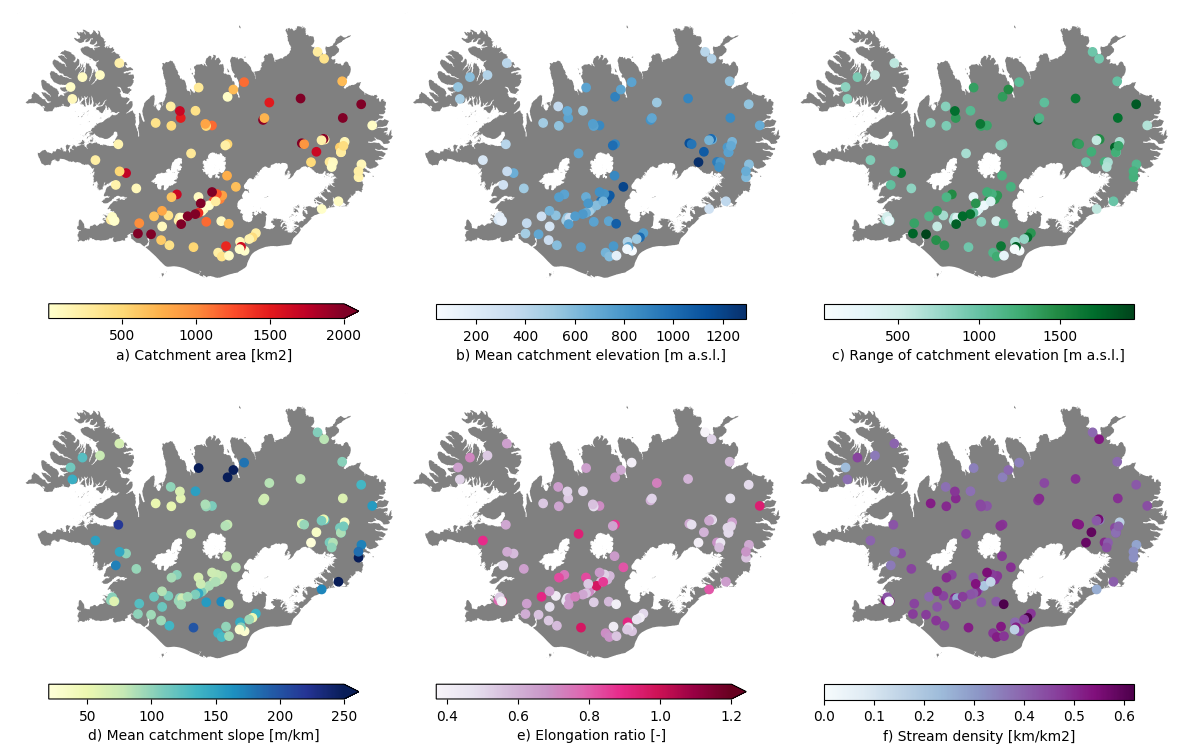

In [186]:
# Topography
topo_cols = ["area_calc","elev_mean","elev_ran","slope_mean","elon_ratio","strm_dens"]
topo_txt = ["a) Catchment area [km2]", "b) Mean catchment elevation [m a.s.l.]", "c) Range of catchment elevation [m a.s.l.]",
              "d) Mean catchment slope [m/km]", "e) Elongation ratio [-]", "f) Stream density [km/km2]"]
topo_col_sh = ["YlOrRd", "Blues", "BuGn",
                 "YlGnBu", "PuRd", "BuPu"]

# define subplot grid
fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(15, 12))

plt.subplots_adjust(hspace=-0.3, wspace=0)

i=0
for col, ax in zip(topo_cols, axs.ravel()):
    plot_figs(bmap,glaciers,ax,iceland_shapefile_color,glaciers_color)
    
    # In the case of area, we set the vmax as 3000 km2
    if i == 0:
        im=merged_dff.plot(column=col,
       legend=True, legend_kwds={'label': topo_txt[i],
                                 'orientation': "horizontal",
                                 'shrink': 0.8, 'pad':0.03,'extend':'max'},
       ax=ax, cmap=topo_col_sh[i],vmax=2000)
        
    # In the case of mean catchment slope, we set the vmax as 250 m/km
    elif i == 3:
        im=merged_dff.plot(column=col,
       legend=True, legend_kwds={'label': topo_txt[i],
                                 'orientation': "horizontal",
                                 'shrink': 0.8, 'pad':0.03,'extend':'max'},
       ax=ax, cmap=topo_col_sh[i],vmax=250)

    # In the case of elongation ratio, we set the vmax as 1.2
    elif i == 4:
        im=merged_dff.plot(column=col, 
       legend=True, legend_kwds={'label': topo_txt[i],
                                 'orientation': "horizontal",
                                 'shrink': 0.8, 'pad':0.03,'extend':'max'},
       ax=ax, cmap=topo_col_sh[i],vmax=1.2)
    
    else:
        im=merged_dff.plot(column=col,
        legend=True, legend_kwds={'label': topo_txt[i],
                                 'orientation': "horizontal",
                                 'shrink': 0.8, 'pad':0.03},
       ax=ax, cmap=topo_col_sh[i]) 

    i+=1

savestr = 'topo_attrs_plot_%s.png' % today_str
plt.savefig(savepath/savestr,dpi=300,bbox_inches='tight')

# 5.2 Climate indices

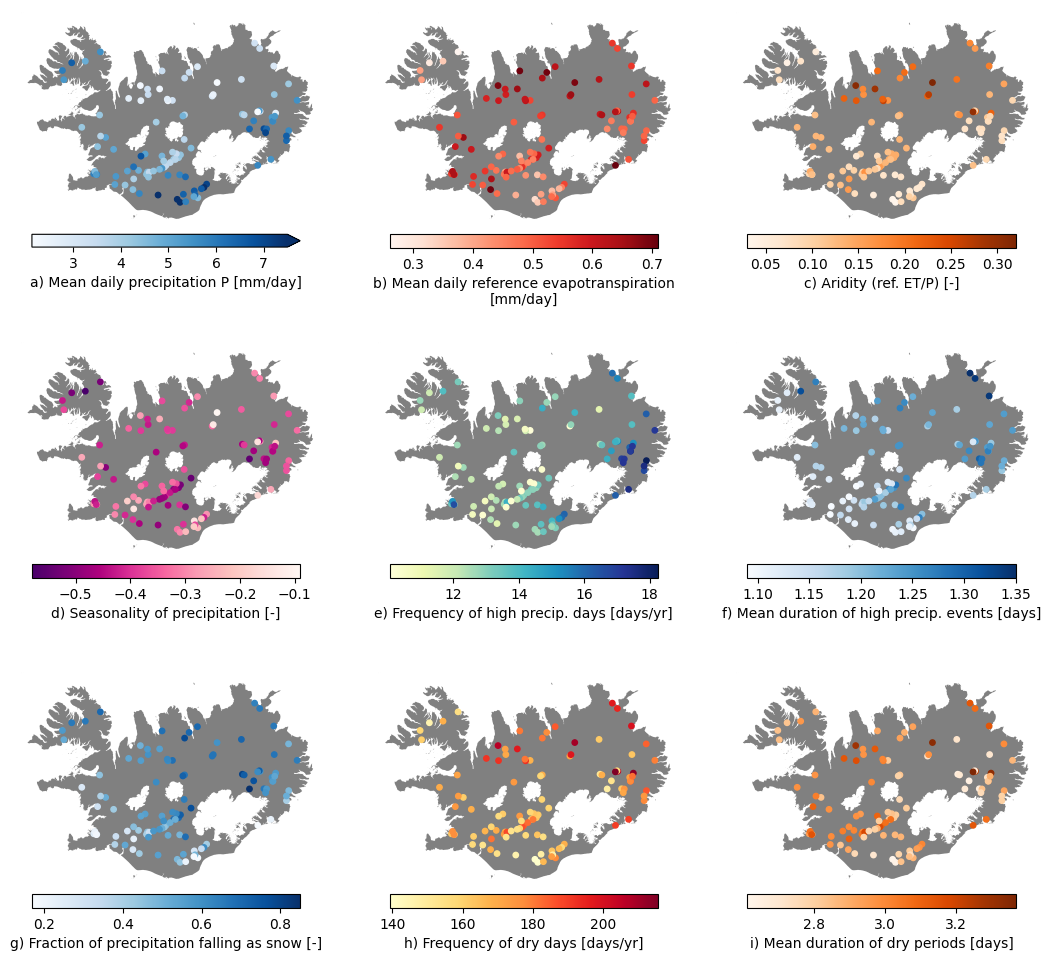

In [187]:
# climate indices
clim_cols = ["p_mean","ref_et_mean","aridity",
             "p_season","high_prec_fr","high_prec_du",
             "frac_snow","lo_prec_fr","low_prec_du"]
clim_txt = ["a) Mean daily precipitation P [mm/day]", "b) Mean daily reference evapotranspiration\n[mm/day]", "c) Aridity (ref. ET/P) [-]",
            "d) Seasonality of precipitation [-]", "e) Frequency of high precip. days [days/yr]", "f) Mean duration of high precip. events [days]",
            "g) Fraction of precipitation falling as snow [-]", "h) Frequency of dry days [days/yr]", "i) Mean duration of dry periods [days]"]
clim_col_sh = ["Blues", "Reds", "Oranges",
                 "RdPu_r", "YlGnBu", "Blues",
                 "Blues", "YlOrRd", "Oranges"]
clim_col_rev = [False,False,False,
                  True,False,False,
                  False,False,False]
clim_col_br = [[2.2,2.8,3.4,4.0,4.6], [0.2,0.4,0.6,0.8,1.0], [0,0.15,0.3,0.45,0.6],
                [-0.4,-0.3,-0.2,-0.1,0], [10,12,14,16,18], [1.12,1.14,1.16,1.18,1.2],
                [0.1,0.2,0.3,0.4,0.5], [100,120,140,160,180], [1.8,2.0,2.2,2.4,2.6]]

extends = ['neither','neither','neither','neither','neither','neither','neither','neither','neither']

# define subplot grid
fig, axs = plt.subplots(nrows=3, ncols=3, figsize=(15, 12))

# plt.subplots_adjust(hspace=0.5)
plt.subplots_adjust(hspace=0.25, wspace=-.2) # adjust hspace and wspace -0.45

i=0
for col, ax in zip(clim_cols, axs.ravel()):
    plot_figs(bmap,glaciers,ax,iceland_shapefile_color,glaciers_color)

    # In the case of Precip, we set the vmax as 8
    if i==0:
        im=merged_dff.plot(column=col,s=15, 
           legend=True, legend_kwds={'label': clim_txt[i],
                                     'orientation': "horizontal",
                                     'shrink': 0.6, 'pad':0.03,'extend':'max'}, ax=ax, cmap=clim_col_sh[i],vmax=7.5)
    else:
        im=merged_dff.plot(column=col,s=15, 
           legend=True, legend_kwds={'label': clim_txt[i],
                                     'orientation': "horizontal",
                                     'shrink': 0.6, 'pad':0.03}, ax=ax, cmap=clim_col_sh[i]) 

    i+=1

savestr = 'climate_indices_plot_%s.png' % today_str
plt.savefig(savepath/savestr,dpi=300,bbox_inches='tight')

In [ ]:
# Print stats mentioned in the paper:

In [21]:
print('Mean ref ET is %s mm' % merged_dff["ref_et_mean"].mean())

Mean ref ET is 0.5210280373831776 mm


In [22]:
print('Mean precip is %s mm' % merged_dff["p_mean"].mean())

Mean precip is 4.741682242990654 mm


# 5.3 Hydrological signatures

In [26]:
# hydro indices
cols = ['q_mean', 'runoff_ratio', 'hfd_mean', 'slope_fdc', 'baseflow_index_ladson', 'stream_elas', 
        'high_q_freq', 'high_q_dur', 'Q95', 'low_q_freq', 'low_q_dur', 'Q5']

cols= [x+'_unfilt' for x in cols]
hydro_row = [cols.index(col) for col in ["q_mean_unfilt","runoff_ratio_unfilt","hfd_mean_unfilt",
                                          "slope_fdc_unfilt","baseflow_index_ladson_unfilt","stream_elas_unfilt",
                                          "high_q_freq_unfilt","high_q_dur_unfilt","Q95_unfilt",
                                          "low_q_freq_unfilt","low_q_dur_unfilt","Q5_unfilt"]]
hydro_txt = ["a) Mean daily discharge Q [mm/d]", "b) Runoff ratio (Q/P) [-]", "c) Mean half-flow date [days since 01. Oct.]",
             "d) Slope of the flow duration curve [-]", "e) Baseflow index [-]", "f) Discharge precipitation elasticity [-]",
             "g) High-flow frequency [days/yr]", "h) Mean high-flow duration [days]", "i) Q95 [mm/d]",
             "j) Low-flow frequency [days/yr]", "k) Mean low-flow duration [days]", "l) Q5 [mm/d]"]
hydro_col_sh = ["Blues", "YlGn", "BuGn",
                  "Oranges", "BuPu", "Reds",
                  "YlGnBu", "Blues", "Blues",
                  "YlOrRd", "Oranges", "Oranges_r"]
hydro_col_rev = [False,False,False,
                    False,False,False,
                    False,False,False,
                    False,False,True]

hydro_col_br = [[2,4,6,8,10,12], [0,0.5,1,1.5,2,2.5,3], [110,140,170,200,230,260,290], #[0,1,2,3],
                    [0,1,2,3,4,5], [0.3,0.4,0.5,0.6,0.7,0.8,0.9], [-1,1,2,3,4,5],
                    [0,5,10,15,20,25], [1,2,3,4,5,6], [0,5,10,15,20,25,30],
                    [0,20,40,60,80,100,120], [0,5,10,15,20,25,30,35], [0,2,4,6,8,10]]

vmaxs = [10,2,290,4.4,0.9,4.4,25,6,30,115,35,10]
extends = ['both','max','min','neither','max','min','max','max','max','neither','max','max']

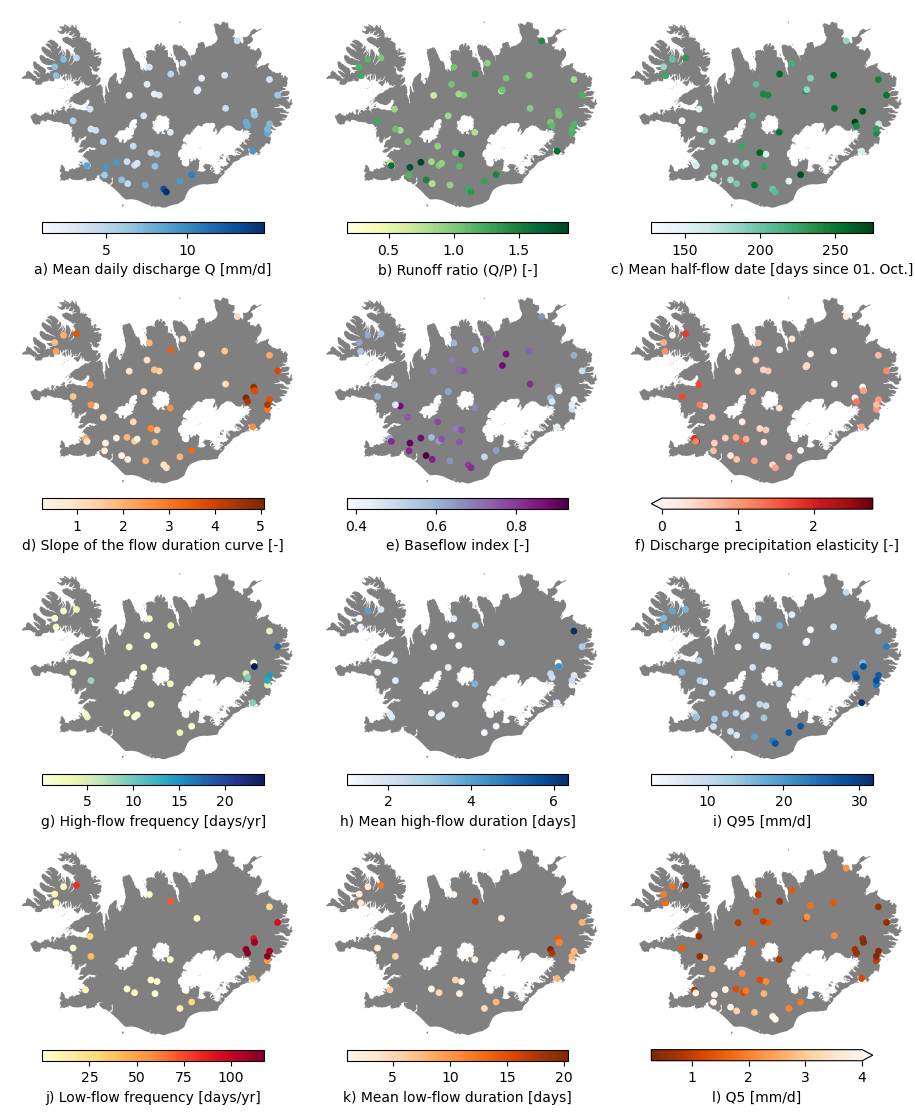

In [68]:
# hydro indices
cols = ['q_mean', 'runoff_ratio', 'hfd_mean', 'slope_fdc', 'baseflow_index_ladson', 'stream_elas', 
        'high_q_freq', 'high_q_dur', 'Q95', 'low_q_freq', 'low_q_dur', 'Q5']

hydro_row = [cols.index(col) for col in ["q_mean","runoff_ratio","hfd_mean",
                                          "slope_fdc","baseflow_index_ladson","stream_elas",
                                          "high_q_freq","high_q_dur","Q95",
                                          "low_q_freq","low_q_dur","Q5"]]
hydro_txt = ["a) Mean daily discharge Q [mm/d]", "b) Runoff ratio (Q/P) [-]", "c) Mean half-flow date [days since 01. Oct.]",
             "d) Slope of the flow duration curve [-]", "e) Baseflow index [-]", "f) Discharge precipitation elasticity [-]",
             "g) High-flow frequency [days/yr]", "h) Mean high-flow duration [days]", "i) Q95 [mm/d]",
             "j) Low-flow frequency [days/yr]", "k) Mean low-flow duration [days]", "l) Q5 [mm/d]"]
hydro_col_sh = ["Blues", "YlGn", "BuGn",
                  "Oranges", "BuPu", "Reds",
                  "YlGnBu", "Blues", "Blues",
                  "YlOrRd", "Oranges", "Oranges_r"]
hydro_col_rev = [False,False,False,
                    False,False,False,
                    False,False,False,
                    False,False,True]

hydro_col_br = [[2,4,6,8,10,12], [0,0.5,1,1.5,2,2.5,3], [110,140,170,200,230,260,290], #[0,1,2,3],
                    [0,1,2,3,4,5], [0.3,0.4,0.5,0.6,0.7,0.8,0.9], [-1,1,2,3,4,5],
                    [0,5,10,15,20,25], [1,2,3,4,5,6], [0,5,10,15,20,25,30],
                    [0,20,40,60,80,100,120], [0,5,10,15,20,25,30,35], [0,2,4,6,8,10]]

vmaxs = [10,2,290,4.4,0.9,4.4,25,6,30,115,35,10]
extends = ['both','max','min','neither','max','min','max','max','max','neither','max','max']

# define subplot grid
fig, axs = plt.subplots(nrows=4, ncols=3, figsize=(15, 14))

# plt.subplots_adjust(hspace=0.5)
plt.subplots_adjust(hspace=0.1, wspace=-0.45) # adjust hspace and wspace

i=0
for col, ax in zip(cols, axs.ravel()):
    plot_figs(bmap,glaciers,ax,iceland_shapefile_color,glaciers_color)
    
    if i==5:
        # In the case of precipitation elasticity, we set the vmin as 0
        im=merged_dff.where(merged_dff['degimpact'] != 's').plot(column=col,s=15, 
               legend=True, legend_kwds={'label': hydro_txt[i],
                                         'orientation': "horizontal",
                                         'shrink': 0.4, 'pad':0.03,
                                        'extend': 'min'}, 
               ax=ax, cmap=hydro_col_sh[i],vmin=0)
    elif i==11:
        # In the case of Q5, we set the vmax as 4
        im=merged_dff.where(merged_dff['degimpact'] != 's').plot(column=col,s=15, 
               legend=True, legend_kwds={'label': hydro_txt[i],
                                         'orientation': "horizontal",
                                         'shrink': 0.4, 'pad':0.03,
                                        'extend': 'max'}, 
               ax=ax, cmap=hydro_col_sh[i],vmax=4)
    else:

        im=merged_dff.where(merged_dff['degimpact'] != 's').plot(column=col,s=15, 
                       legend=True, legend_kwds={'label': hydro_txt[i],
                                                 'orientation': "horizontal",
                                                 'shrink': 0.4, 'pad':0.03},
                       ax=ax, cmap=hydro_col_sh[i])

    i+=1

savestr = 'streamflow_indices_plot_%s.png' % today_str
plt.savefig(savepath/savestr,dpi=300,bbox_inches='tight')

In [85]:
print('Mean runoff ratio is %s [-]' % merged_dff["runoff_ratio"].where(merged_dff['degimpact']!='s').mean())

Mean runoff ratio is 1.0983624450488585 [-]


In [86]:
print('Mean baseflow index is %s [-]' % merged_dff["baseflow_index_ladson"].where(merged_dff['degimpact']!='s').mean())

Mean baseflow index is 0.6626174794846653 [-]


In [89]:
print('Mean runoff-precip elasticity is %s' % merged_dff["stream_elas"].where(merged_dff['degimpact']!='s').mean())

Mean runoff-precip elasticity is 0.6345977083811147


In [90]:
len(merged_dff["stream_elas"].where(merged_dff['degimpact']!='s').dropna())

55

In [50]:
# Check correlations between catchment characteristics:
numeric_columns_hydro = merged_dff.where(merged_dff['degimpact']!='s').select_dtypes(include=['number'])
corr_hydro = numeric_columns_hydro.corr()

In [91]:
corr_hydro['baseflow_index_ladson'].sort_values().head(10)

g_lon                -0.819488
slope_fdc_unfilt     -0.811158
slope_fdc            -0.805113
high_q_freq_unfilt   -0.784899
high_q_freq          -0.770765
low_q_freq_unfilt    -0.739270
low_q_freq           -0.688450
gc_23_vbsr           -0.687793
ggold_fra            -0.678559
high_prec_fr_ERA5L   -0.637347
Name: baseflow_index_ladson, dtype: float64

In [48]:
corr_hydro['baseflow_index_ladson'].sort_values().tail(10)

PET_ravII_1981           0.390806
gc_23_vbpy               0.396259
gmob_fra                 0.405326
gbnew_fra                0.491426
year_count_1981_2021     0.550753
gbold_fra                0.671430
Q5                       0.673704
gc_23_vb                 0.676707
baseflow_index_ladson    1.000000
g746_fra                      NaN
Name: baseflow_index_ladson, dtype: float64

# 5.4 Land Cover Characteristics

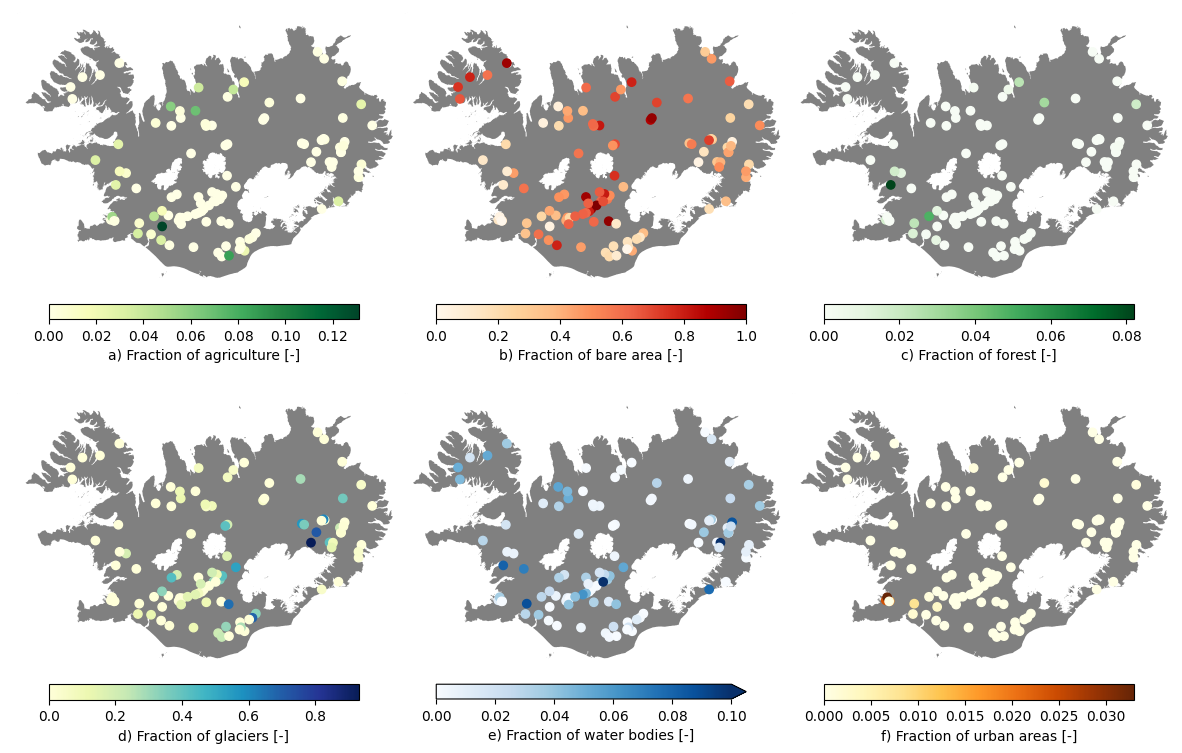

In [193]:
# landclasses
lc_cols = ["agr_fra", "bare_fra", "forest_fra", "glac_fra", "lake_fra", "urban_fra"]
lc_txt = ["a) Fraction of agriculture [-]", "b) Fraction of bare area [-]", "c) Fraction of forest [-]",
          "d) Fraction of glaciers [-]", "e) Fraction of water bodies [-]", "f) Fraction of urban areas [-]"]
lc_col_sh = ["YlGn", "OrRd", "Greens", "YlGnBu", "Blues", "YlOrBr"]
lc_col_rev = [False, False, False, False, False, False]
lc_col_br = [[0.1, 0.2, 0.4, 0.6, 0.8], [0.01, 0.05, 0.1, 0.2, 0.4], [0.1, 0.2, 0.4, 0.6, 0.8],
             [0.01, 0.02, 0.03, 0.05, 0.1], [0.01, 0.02, 0.03, 0.04, 0.05], [0.01, 0.05, 0.1, 0.15, 0.2]]

# define subplot grid
fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(15, 12))

plt.subplots_adjust(hspace=-0.3, wspace=0)##-.2) # adjust hspace and wspace -0.45

i=0
for col, ax in zip(lc_cols, axs.ravel()):
    plot_figs(bmap,glaciers,ax,iceland_shapefile_color,glaciers_color)
    
    # In the case of lake fractions, we set the vmax as 0.2
    if i == 4:
        im=merged_dff.plot(column=col,
           legend=True, legend_kwds={'label': lc_txt[i],
                                     'orientation': "horizontal",
                                     'shrink': 0.8, 'pad':0.03,'extend':'max'},ax=ax, cmap=lc_col_sh[i], vmax=0.1)
        
    else:
        im=merged_dff.plot(column=col,#s=15, 
           legend=True, legend_kwds={'label': lc_txt[i],
                                     'orientation': "horizontal",
                                     'shrink': 0.8, 'pad':0.03}, ax=ax, cmap=lc_col_sh[i]) 

    i+=1

savestr = 'landcover_classes_%s.png' % today_str
plt.savefig(savepath/savestr,dpi=300,bbox_inches='tight')

In [194]:
# Print statistics about land cover classes in LamaH-Ice:
100*merged_dff[["agr_fra", "bare_fra", "forest_fra", "glac_fra", "lake_fra", "urban_fra"]].mean()

agr_fra        0.831776
bare_fra      44.229907
forest_fra     0.293458
glac_fra      12.480374
lake_fra       2.327103
urban_fra      0.085047
dtype: float64

# 5.5 Vegetation indices

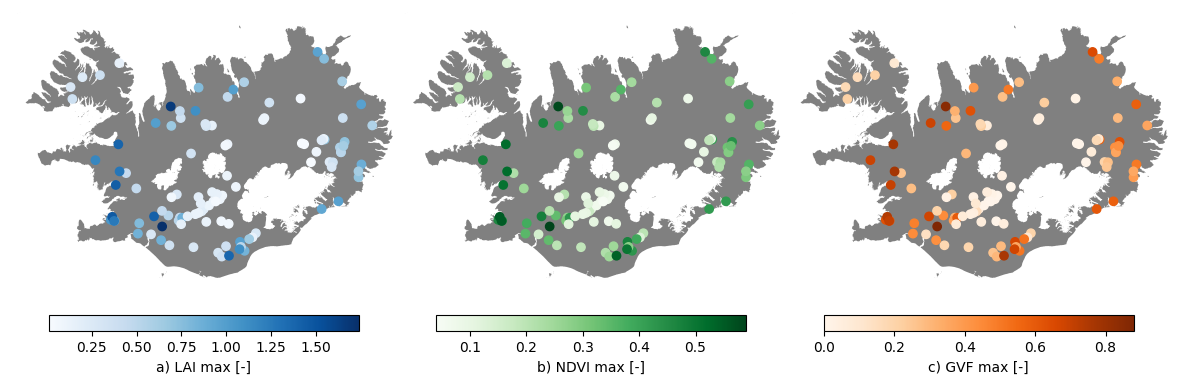

In [202]:
# Vegetation indices - Skipping the lower panel:
# Vegetation
veg_cols = ["lai_max","ndvi_max","gvf_max"]
veg_txt = ["a) LAI max [-]", "b) NDVI max [-]", "c) GVF max [-]"]
veg_col_sh = ["Blues", "Greens", "Oranges"]

# define subplot grid
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(15, 12))

plt.subplots_adjust(hspace=-0.3, wspace=0)

i=0
for col, ax in zip(veg_cols, axs.ravel()):
    plot_figs(bmap,glaciers,ax,iceland_shapefile_color,glaciers_color)
    
    im=merged_dff.plot(column=col,#s=15, 
       legend=True, legend_kwds={'label': veg_txt[i],
                                 'orientation': "horizontal",
                                 'shrink': 0.8, 'pad':0.03}, 
       ax=ax, cmap=veg_col_sh[i])

    i+=1

savestr = 'veg_indices_plot_final_%s.png' % today_str
plt.savefig(savepath/savestr,dpi=300,bbox_inches='tight')

# 5.6 Surface deposits and soil characteristics

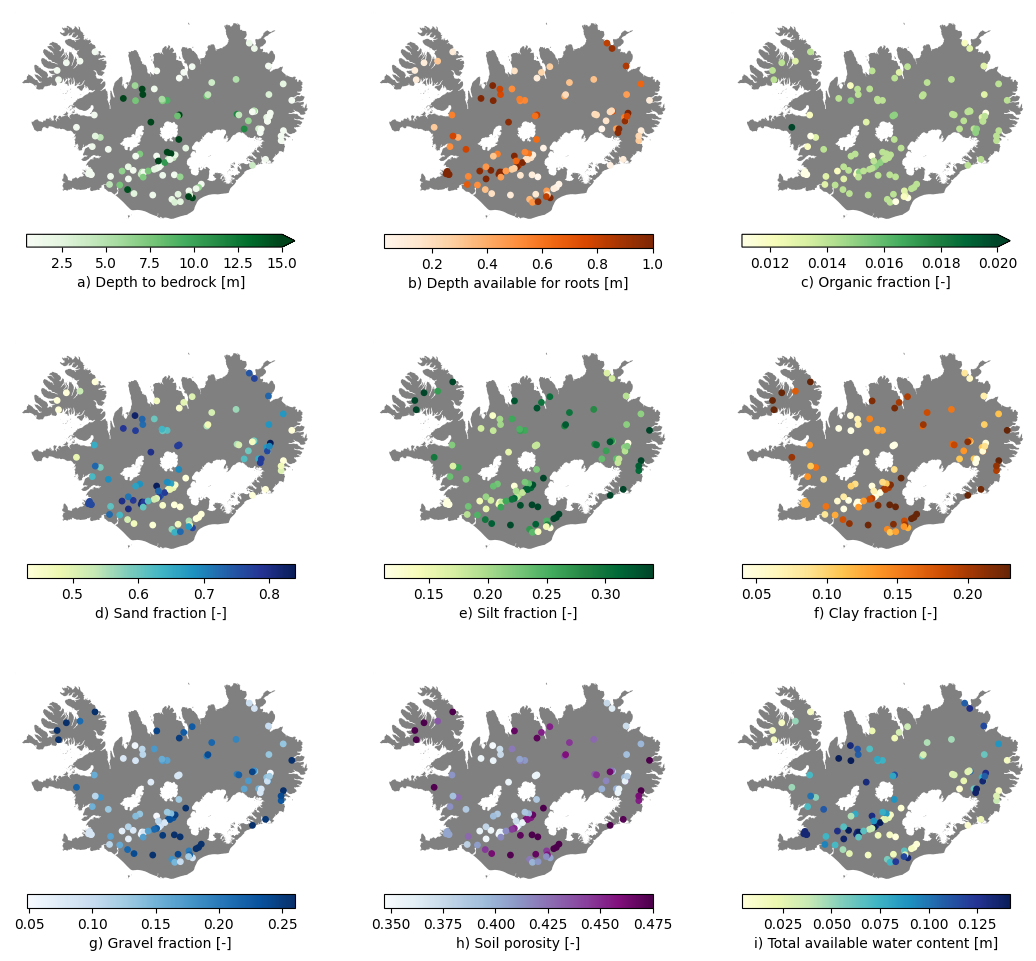

In [203]:
soil_cols = ["bedrk_dep", "root_dep", "oc_fra", "sand_fra", "silt_fra", "clay_fra",
"grav_fra", "soil_poros", "soil_tawc"]
soil_txt = ["a) Depth to bedrock [m]", "b) Depth available for roots [m]", "c) Organic fraction [-]",
"d) Sand fraction [-]", "e) Silt fraction [-]", "f) Clay fraction [-]",
"g) Gravel fraction [-]", "h) Soil porosity [-]", "i) Total available water content [m]"]
soil_col_sh = ["Greens", "Oranges", "YlGn", "YlGnBu", "YlGn", "YlOrBr", "Blues", "BuPu", "YlGnBu"]

# define subplot grid
fig, axs = plt.subplots(nrows=3, ncols=3, figsize=(15, 12))

plt.subplots_adjust(hspace=0.25, wspace=-.2) 

i=0
for col, ax in zip(soil_cols, axs.ravel()):
    plot_figs(bmap,glaciers,ax,iceland_shapefile_color,glaciers_color)
    
    # In the case of depth to bedrock, we set the vmax as 15
    if i==0:
        
        im=merged_dff.plot(column=col,s=15, 
               legend=True, legend_kwds={'label': soil_txt[i],
                                         'orientation': "horizontal",
                                         'shrink': 0.6, 'pad':0.03,
                                        'extend': 'max'}, 
               ax=ax, cmap=soil_col_sh[i],vmax=15)
    elif i==2:
        im=merged_dff.plot(column=col,s=15, 
           legend=True, legend_kwds={'label': soil_txt[i],
                                     'orientation': "horizontal",
                                     'shrink': 0.6, 'pad':0.03,
                                    'extend': 'max'},
           ax=ax, cmap=soil_col_sh[i],vmax=0.02)
    else:
        im=merged_dff.plot(column=col,s=15, 
           legend=True, legend_kwds={'label': soil_txt[i],
                                     'orientation': "horizontal",
                                     'shrink': 0.6, 'pad':0.03},
           ax=ax, cmap=soil_col_sh[i]) 


    i+=1

savestr = 'soil_indices_plot_%s.png' % today_str
plt.savefig(savepath/savestr,dpi=300,bbox_inches='tight')

In [ ]:
# Print stats mentioned in paper:

In [57]:
print('The average values for the soil attributes are as follows:')
merged_dff[soil_cols].mean()

The average values for the soil attributes are as follows:


bedrk_dep     5.117776
root_dep      0.508421
oc_fra        0.013645
sand_fra      0.615972
silt_fra      0.244645
clay_fra      0.137430
grav_fra      0.163776
soil_poros    0.415318
soil_tawc     0.070439
dtype: float64

In [61]:
print('Correlations for root depth to other catchment attributes:')
corr['root_dep'].sort_values()

Correlations for root depth to other catchment attributes:


grav_fra     -0.951647
silt_fra     -0.944935
soil_poros   -0.893942
clay_fra     -0.888594
elev_std     -0.519734
                ...   
ndvi_max      0.465660
ggnew_fra     0.492961
sand_fra      0.949675
soil_tawc     0.997311
root_dep      1.000000
Name: root_dep, Length: 119, dtype: float64

# 5.7 Geological characteristics

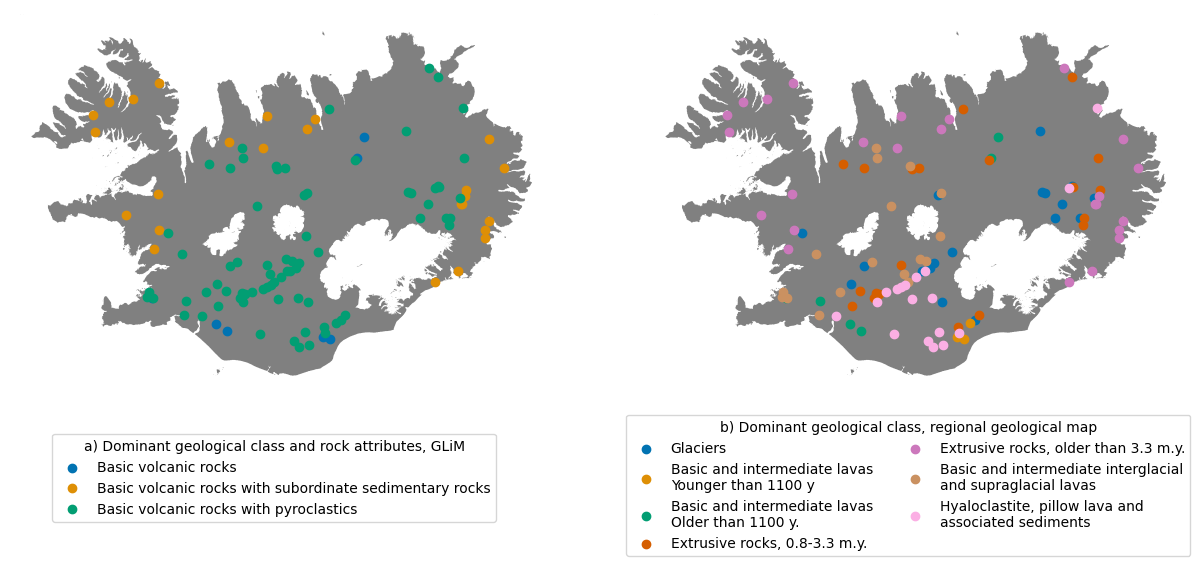

In [208]:
import matplotlib.pyplot as plt
import seaborn as sns

# Dominant geological attributes
g_dom_titles = dict()
g_dom_titles['621'] = 'Glaciers'
g_dom_titles['743'] = 'Lakes'
g_dom_titles['bnew'] = 'Basic and intermediate lavas\nYounger than 1100 y'
g_dom_titles['bold'] = 'Basic and intermediate lavas\nOlder than 1100 y.'
g_dom_titles['gnew'] = 'Extrusive rocks, 0.8-3.3 m.y.'
g_dom_titles['gold'] = 'Extrusive rocks, older than 3.3 m.y.'
g_dom_titles['hraun'] = 'Basic and intermediate interglacial\nand supraglacial lavas'
g_dom_titles['mob'] = 'Hyaloclastite, pillow lava and\nassociated sediments'
g_dom_titles['sgos'] = 'Acid extrusives'

g_dom_titles['vb____'] = 'Basic volcanic rocks'
g_dom_titles['vb__sr'] = 'Basic volcanic rocks with subordinate sedimentary rocks'
g_dom_titles['vbpy__'] = 'Basic volcanic rocks with pyroclastics'

geo_cols = ["gc_dom","gc_mt_fra","gc_sc_fra",
                    "gc_sm_fra","geol_poros","geol_perme","gc_23_dom","g_dom_NI"]
geo_txt = ["a) Dominant geologic class", "b) Fraction of metamorphics (mt) [-]", "c) Fraction of carbonate sedimentary rocks (sc) [-]",
              "d) Fraction of mixed sedimentary rocks (sm) [-]", "e) Subsurface porosity [-]", "f) Subsurface permeability [m2, log scale]"]
geo_col_sh = ["Oranges", "Oranges", "Blues",
                 "Greens", "YlGnBu", "YlGn"]

geo_cols = ["gc_23_dom","g_dom_NI"]

# Choose a color palette from seaborn that is suitable for color vision deficiencies
colorblind_palette = sns.color_palette("colorblind", n_colors=len(g_dom_titles))

# Define subplot grid
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(15, 12))

i = 0
for col, ax in zip(geo_cols, axs.ravel()):
    plot_figs(bmap, glaciers, ax, iceland_shapefile_color, glaciers_color)
    
    groups = merged_dff.groupby(col)

    for j, (name, group) in enumerate(groups):
        group.plot(ax=ax, label=g_dom_titles[name], color=colorblind_palette[j])
    
    if i == 0:
        ax.legend(title='a) Dominant geological class and rock attributes, GLiM', loc='upper center', bbox_to_anchor=(0.5, -0.1), ncol=1)
    else:
        ax.legend(title='b) Dominant geological class, regional geological map', loc='upper center', bbox_to_anchor=(0.5, -0.05), ncol=2)

    i += 1

savestr = 'geo_classes_plot_%s.png' % today_str
plt.savefig(savepath / savestr, dpi=300, bbox_inches='tight')

# 5.9 Natural or anthropogenic impacts on runoff

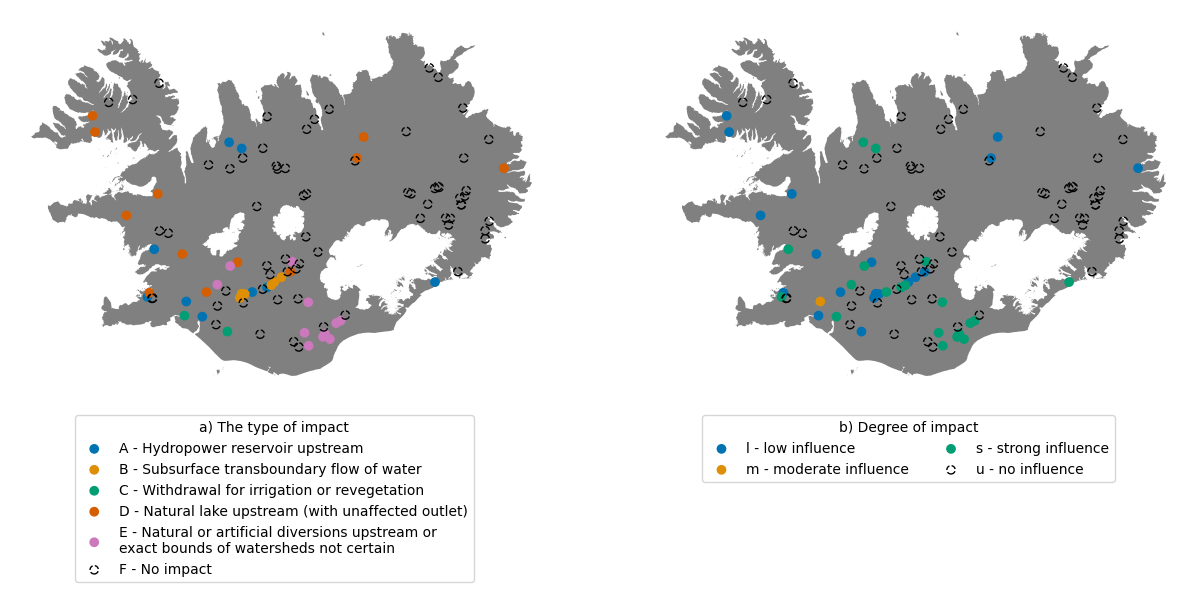

In [210]:
# Impact texts:
impact_titles = {
    'A': 'A - Hydropower reservoir upstream',
    'B': 'B - Subsurface transboundary flow of water',
    'C': 'C - Withdrawal for irrigation or revegetation',
    'D': 'D - Natural lake upstream (with unaffected outlet)',
    'E': 'E - Natural or artificial diversions upstream or\nexact bounds of watersheds not certain',
    'F': 'F - No impact',
    'l': 'l - low influence',
    'u': 'u - no influence',
    's': 's - strong influence',
    'm': 'm - moderate influence'
}

# Choose a color palette from seaborn that is suitable for color vision deficiencies
palette = sns.color_palette("colorblind", n_colors=len(impact_titles))

# Define subplot grid
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(15, 12))

i = 0
for col, ax in zip(['typimpact', 'degimpact'], axs.ravel()):
    plot_figs(bmap, glaciers, ax, iceland_shapefile_color, glaciers_color)

    groups = merged_dff.groupby(col)

    for j, (name, group) in enumerate(groups):
        if i == 1:
            if name == 'u':
                group.plot(ax=ax, label=impact_titles[name], color='black',marker='o',facecolors='none',linestyle='--')
            else:
                group.plot(ax=ax, label=impact_titles[name], color=palette[j], hatch='////')
        else:
            if name == 'F':
                group.plot(ax=ax, label=impact_titles[name], color='black',marker='o',facecolors='none',linestyle='--')
            else:
                group.plot(ax=ax, label=impact_titles[name], color=palette[j], hatch='////')
    
    if i == 0:
        ax.legend(title='a) The type of impact', loc='upper center', bbox_to_anchor=(0.5, -0.05), ncol=1)
    else:
        ax.legend(title='b) Degree of impact', loc='upper center', bbox_to_anchor=(0.5, -0.05), ncol=2)

    i += 1

savestr = 'human_influence_plot_%s.png' % today_str
plt.savefig(savepath / savestr, dpi=300, bbox_inches='tight')
